## **Model Building - Approach**

1. Data preparation.
2. Partition the data into a train and test set.
3. Build a model on the train data.
4. Tune the model if required.
5. Test the data on the test set.

### **Importing the libraries and overview of the dataset**

In [207]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
import sklearn.ensemble

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import optuna
import shap

import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
nltk.download('stopwords')
import string


from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# import lightgbm as lgb

[nltk_data] Downloading package stopwords to /Users/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Define Metrics**


In [208]:
# Creating metric function

def metrics_score(actual, predicted):
    
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Negative', 'Positive'], yticklabels = ['False', 'True'])
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

In [209]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    
    predictors: independent variables
    
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
               
    acc = accuracy_score(target, pred)                                 # To compute accuracy score
    

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },
        
        index = [0],
    )

    return df_perf

### **Loading the Dataset**

In [210]:
data = pd.read_csv("./kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### **Dataset**¶
We use the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

### **EDA**

In [211]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS

In [212]:
data.dtypes

target        int64
ids           int64
date         object
flag         object
user         object
TweetText    object
dtype: object

In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1599999 non-null  int64 
 1   ids        1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   flag       1599999 non-null  object
 4   user       1599999 non-null  object
 5   TweetText  1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [214]:
data.nunique()

target             2
ids          1598314
date          774362
flag               1
user          659775
TweetText    1581465
dtype: int64

In [215]:
data.describe(include='all')

,target,ids,date,flag,user,TweetText
count,1.599999e+06,1.599999e+06,1599999,1599999,1599999,1599999
unique,NaN,NaN,774362,1,659775,1581465
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1599999,549,210
mean,2.000001e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935757e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,4.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


### **Data Preprocessing**

In [216]:
n_samples = 160

positif_data = data[data.target==4].iloc[:n_samples,:]
print(positif_data.shape)
negative_data = data[data.target==0].iloc[:n_samples,:]
print(negative_data.shape)
data = pd.concat([positif_data,negative_data],axis = 0)
print(data.shape)
data.head()

(160, 6)
(160, 6)
(320, 6)


,target,ids,date,flag,user,TweetText
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [217]:

# Removing Twitter Handles (@user)
data['Clean_TweetText'] = data['TweetText'].str.replace("@", "") 
# Removing links
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace(r"http\S+", "") 
# Removing Punctuations, Numbers, and Special Characters
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
# Remove stop words

stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
data.head()

,target,ids,date,flag,user,TweetText,Clean_TweetText
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health uandpets u guys r best
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter add sunisa got ...
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [218]:
# Text Tokenization and Normalization
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: nltk.word_tokenize(x))
data.head()

,target,ids,date,flag,user,TweetText,Clean_TweetText
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpets, u, guys, r, best]"
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,"[im, meeting, one, besties, tonight, cant, wai..."
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thanks, twitter, add, sunisa..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,"[sick, really, cheap, hurts, much, eat, real, ..."
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyone]"


In [219]:
# Now let’s stitch these tokens back together
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
# Removing small words
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head()

,target,ids,date,flag,user,TweetText,Clean_TweetText
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health uandpets guys best
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,meeting besties tonight cant wait girl talk
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter sunisa meet sho...
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much real food plus fr...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [220]:

# Map target to 4 to 1
data['target'].replace(4,1,inplace=True)
data.head()



,target,ids,date,flag,user,TweetText,Clean_TweetText
799999,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health uandpets guys best
800000,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,meeting besties tonight cant wait girl talk
800001,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter sunisa meet sho...
800002,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much real food plus fr...
800003,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


### **Building the Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample, a decision tree makes a prediction. 

**The results from all the decision trees are combined and the final prediction is made using voting (for classification problems) or averaging (for regression problems).**

In [221]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(data['Clean_TweetText'])
cv.shape

(320, 1200)

In [222]:
x_train,x_test,y_train,y_test = train_test_split(cv,data['target'] , test_size=.2,stratify=data['target'], random_state=42)

In [223]:
# 1. Define an objective function to be maximized.
'''

def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
         classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)
    ...
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
'''

"\n\ndef objective(trial):\n\n    # 2. Suggest values for the hyperparameters using a trial object.\n    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])\n    if classifier_name == 'SVC':\n         svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)\n         classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')\n    else:\n        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)\n        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)\n    ...\n    return accuracy\n\n# 3. Create a study object and optimize the objective function.\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=100)\n"

In [224]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(random_state = 1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



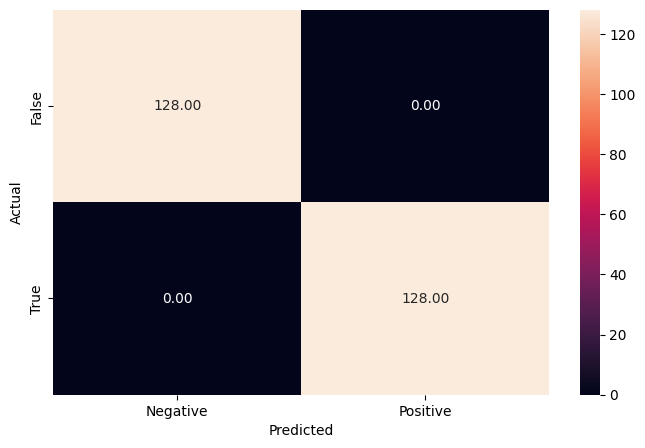

In [225]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.56      0.91      0.69        32
           1       0.75      0.28      0.41        32

    accuracy                           0.59        64
   macro avg       0.65      0.59      0.55        64
weighted avg       0.65      0.59      0.55        64



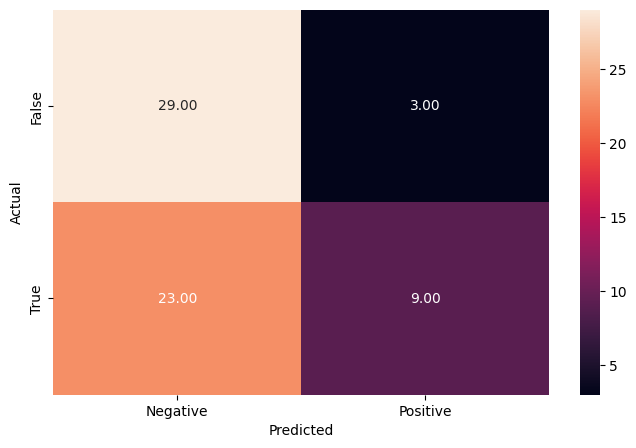

In [226]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [227]:
rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
rf_estimator_test

,Precision,Recall,Accuracy
0,0.653846,0.59375,0.59375


In [234]:
# print(cv)


  (0, 706)	1
  (0, 404)	1
  (0, 1185)	1
  (0, 408)	1


In [228]:
'''
importances = rf_estimator.feature_importances_

columns = cv.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)
'''

AttributeError: columns not found

### **Tuning the Random Forest**

**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node.

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

In [235]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [100, 250, 500],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [236]:
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(max_features='auto', min_samples_leaf=3, random_state=1)

              precision    recall  f1-score   support

           0       0.62      0.93      0.74       128
           1       0.86      0.42      0.57       128

    accuracy                           0.68       256
   macro avg       0.74      0.68      0.65       256
weighted avg       0.74      0.68      0.65       256



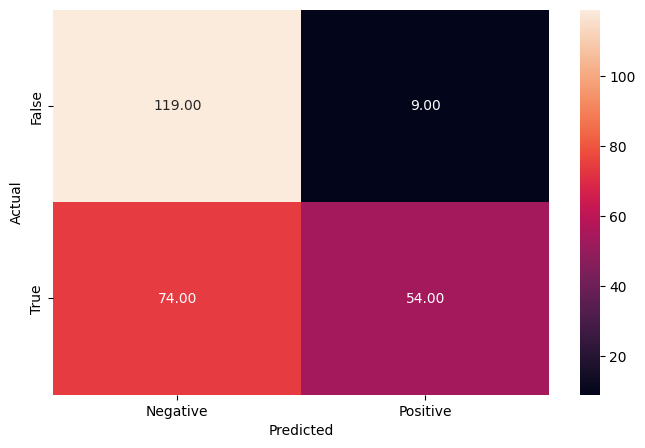

In [237]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)

metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.55      0.81      0.66        32
           1       0.65      0.34      0.45        32

    accuracy                           0.58        64
   macro avg       0.60      0.58      0.55        64
weighted avg       0.60      0.58      0.55        64



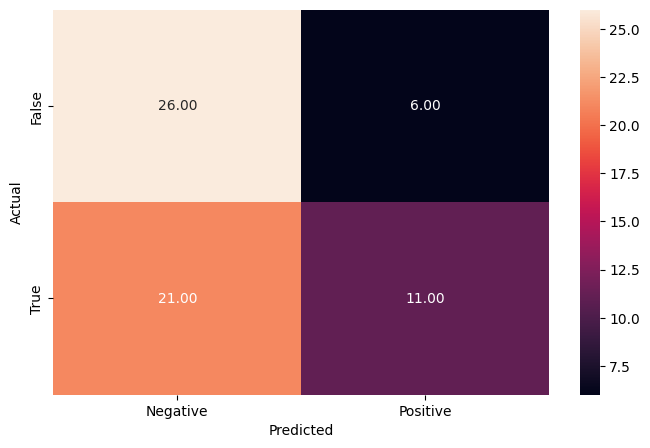

In [238]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)

metrics_score(y_test, y_pred_test_rf_tuned)

In [239]:
rf_estimator_tuned_test = model_performance_classification(rf_estimator_tuned, x_test, y_test)
rf_estimator_tuned_test

,Precision,Recall,Accuracy
0,0.600125,0.578125,0.578125


In [240]:
'''
# Plotting feature importance
importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)

'''

NameError: name 'X' is not defined